In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

# для загрузки из интернетаё
from skimage import io

# version=4.10.0
import cv2 as cv
import cv2

In [2]:
class Shower:
    def show_img(
        img_mtx: np.ndarray, 
        extra_img_params: dict = {}, 
        in_gray: bool=True, 
        is_show: bool=True,
        figsize: tuple=None,
        in_brg: bool=True
    ):
        '''
            cmap='gray': display the image in grayscale
        '''
        img_mtx_cp = img_mtx.copy()
        if in_brg and in_gray is False:
            img_mtx_cp = img_mtx_cp[:, :, ::-1]
        
        if in_gray:
            img_params = {'X': img_mtx_cp} | {'cmap':'gray'} | extra_img_params
        else:
            img_params ={'X': img_mtx_cp} | extra_img_params

            
        if figsize is not None:
            plt.figure(figsize=figsize)
        

        plt.imshow(**img_params)
        plt.axis('off')


        if is_show:
            plt.show()


    def show_two_img(
        img_mtx1: np.ndarray, 
        img_mtx2: np.ndarray,
        title_img1: str = None,
        title_img2: str = None,
        extra_img1_params: dict = {},
        extra_img2_params: dict = {},
        figsize: tuple=(8, 12)
    ):
        plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        Shower.show_img(img_mtx1, extra_img1_params, is_show=False)
        if title_img1:
            plt.title(title_img1)

        plt.subplot(1, 2, 2)
        Shower.show_img(img_mtx2, extra_img2_params, is_show=False)
        if title_img2:
            plt.title(title_img2)

        plt.tight_layout() # fit into the figure area without overlapping
        plt.show()

In [3]:
def findGreatesContour(contours):
    largest_area = 0
    largest_contour_index = -1
    i = 0
    total_contours = len(contours)
    while (i < total_contours ):
        area = cv2.contourArea(contours[i])
        if(area > largest_area):
            largest_area = area
            largest_contour_index = i
        i+=1

    return largest_area, largest_contour_index

Поиск объекта

In [4]:
class ImgDetectionsHSV:

    def __init__(
        self, 
        color: str,
        threshold: int = 254,
        print_steps: bool=True
    ):
        """Expected colors:
            red and green
        """
        colors_masks = {
            'red': {
                'mask1': ((0,50,20), (5,255,255)),
                'mask2': ((175, 50, 20), (180, 255, 255)),
                'main': [0, 0, 255]
            },
            'green': {
                'mask1': ((40, 100, 100), (80, 255, 255)),
                'mask2': ((80, 100, 100), (100, 255, 255)),
                'main': [0, 255, 0]
            }
        }
        self.color = colors_masks[color]
        self.print_steps = print_steps
        self.threshold = threshold

    def find_by_color(self, baseImage, rgbConverted, in_brg=True):
        # Преобразуем в HSV
        imageHSV = cv.cvtColor(baseImage, cv.COLOR_RGB2HSV)

        # Маски для цвета
        mask1 = cv2.inRange(imageHSV, *self.color['mask1'])
        mask2 = cv2.inRange(imageHSV, *self.color['mask2'])

        # Cоздание общей маски
        mask = cv2.bitwise_or(mask1, mask2)
        onlyColor = cv2.bitwise_and(rgbConverted, rgbConverted, mask=mask)

        # Изображение после открытия
        kernel = np.ones((9, 9), np.uint8)
        opening = cv2.morphologyEx(onlyColor, cv2.MORPH_OPEN, kernel)

        # Изображение после наложения маски для унификации цвета
        resultImage = imageHSV.copy()
        resultImage[(mask > 0)] = self.color['main']

        # RGB Изображение после наложения маски
        imageRGB = cv2.cvtColor(resultImage, cv2.COLOR_HSV2BGR)

        # Изображение после преобразования HSV к оттенкам серого
        gray = cv2.cvtColor(imageRGB, cv2.COLOR_BGR2GRAY)

        # Пороговое изображение
        _, threshold = cv2.threshold(gray, self.threshold, 255, cv.THRESH_BINARY)

        if self.print_steps:
            print("Цветовой канал")
            Shower.show_img(onlyColor, in_gray=False, in_brg=in_brg)

            print("Изображение после открытия")
            Shower.show_img(opening, in_gray=False, in_brg=in_brg)

            print("Изображение после конвертации в HSV")
            Shower.show_img(imageHSV, in_gray=False, in_brg=in_brg)

            print("Изображение после наложения маски для унификации цвета")
            Shower.show_img(resultImage, in_gray=False, in_brg=in_brg)

            print("RGB Изображение после наложения маски")
            Shower.show_img(imageRGB, in_gray=False, in_brg=in_brg)

            print("Изображение после преобразования HSV к оттенкам серого")
            Shower.show_img(gray, in_brg=in_brg)

            print("Пороговое изображение")
            Shower.show_img(threshold, in_brg=in_brg)

        return threshold

    def _find_contour(
        self, threshold, rgbConverted, in_brg, idx=-1
    ):
        # Поиск контура
        counturResult = np.zeros(rgbConverted.shape, dtype=np.uint8)
        copyImage = rgbConverted.copy()

        contours, hierarchy = cv2.findContours(
            threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(counturResult, contours, idx, self.color['main'], 3)
        cv2.drawContours(copyImage, contours, idx, self.color['main'], 3)

        # Изображение после открытия
        kernel = np.ones((9, 9), np.uint8)
        opening = cv2.morphologyEx(counturResult, cv2.MORPH_OPEN, kernel)

        if self.print_steps:
            print("Контур")
            Shower.show_img(
                cv.hconcat((counturResult, copyImage)),
                in_gray=False,
                in_brg=in_brg
            )

            print("Изображение после открытия")
            Shower.show_img(opening, in_gray=False, in_brg=in_brg)

        return kernel, contours


    def find_contour(self, threshold, rgbConverted, in_brg=True):
        kernel, _ = self._find_contour(threshold, rgbConverted, in_brg)

        # Открытие на пороговое изображение
        opening_thshld = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel)

        kernel, contours_thshld = self._find_contour(
            opening_thshld, rgbConverted, in_brg
        )

        # Сортировка контура и поиска самого большого
        _, index = findGreatesContour(contours_thshld)

        counturResult_idx = np.zeros(rgbConverted.shape, dtype=np.uint8)
        cv2.drawContours(counturResult_idx, contours_thshld,
                         index, self.color['main'], 3)

        if self.print_steps:
            print("Открытие на пороговое изображение")
            Shower.show_img(opening_thshld, in_brg=in_brg)

            print("Контур самый большой")
            Shower.show_img(counturResult_idx, in_gray=False, in_brg=in_brg)

Оригнальное изображение


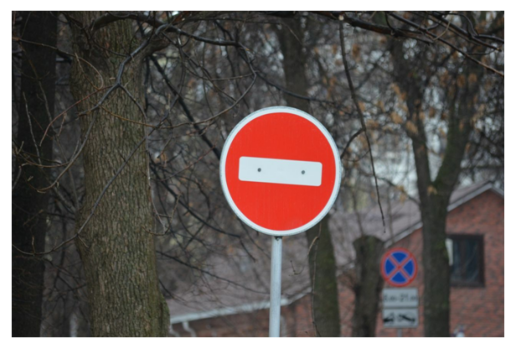

Цветовой канал


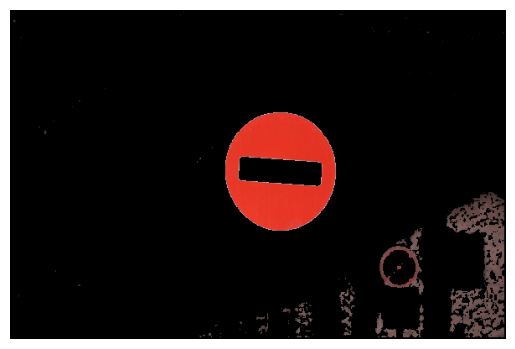

Изображение после открытия


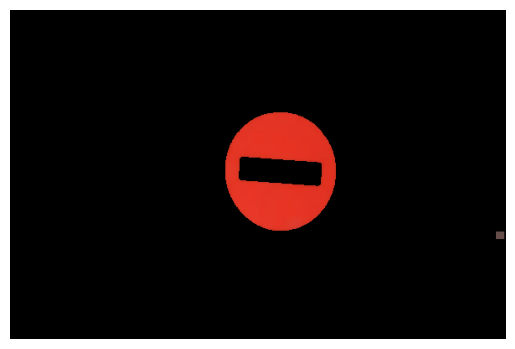

Изображение после конвертации в HSV


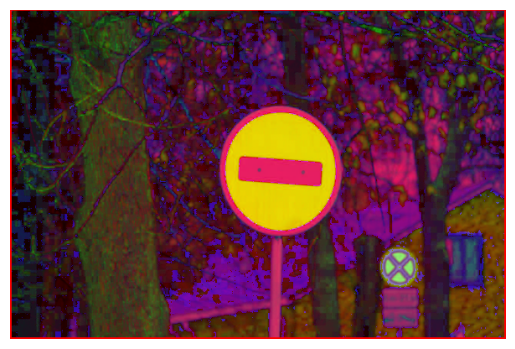

Изображение после наложения маски для унификации цвета


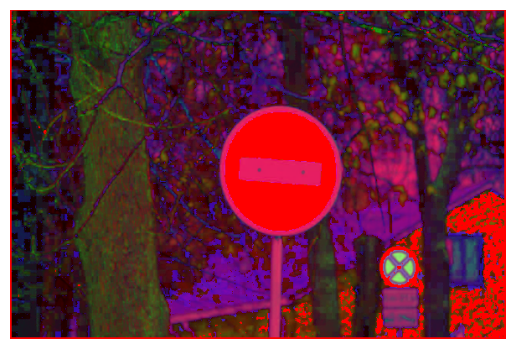

RGB Изображение после наложения маски


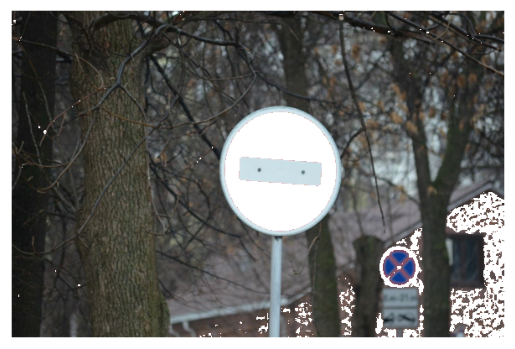

Изображение после преобразования HSV к оттенкам серого


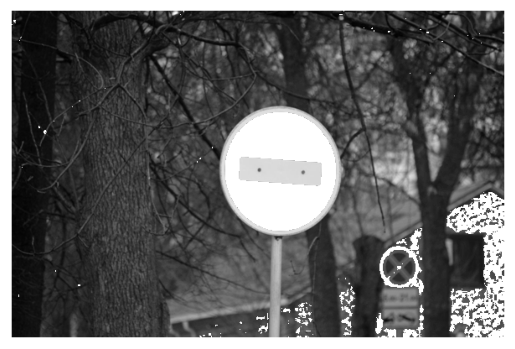

Пороговое изображение


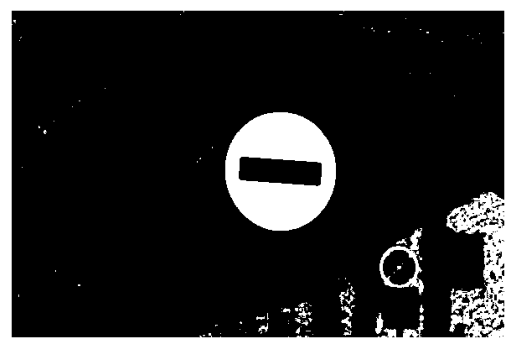

Контур


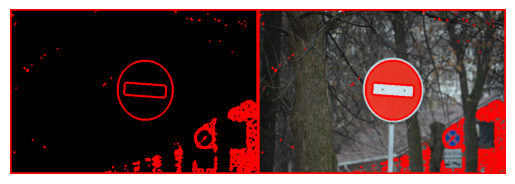

Изображение после открытия


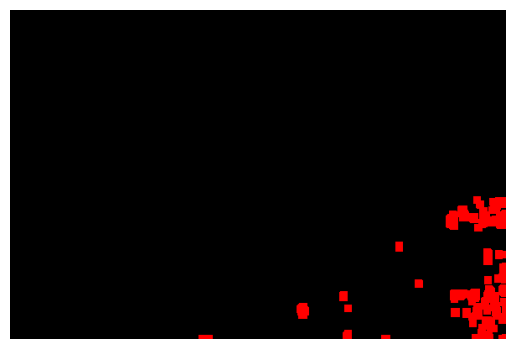

Контур


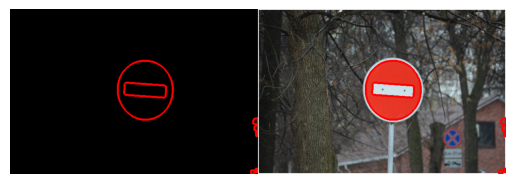

Изображение после открытия


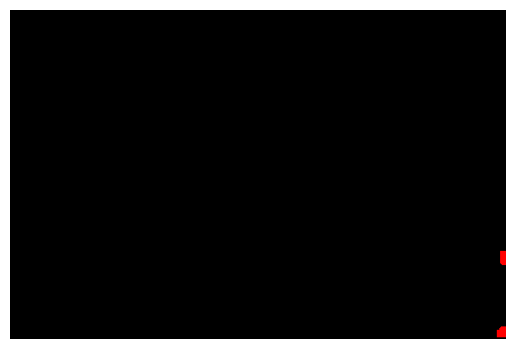

Открытие на пороговое изображение


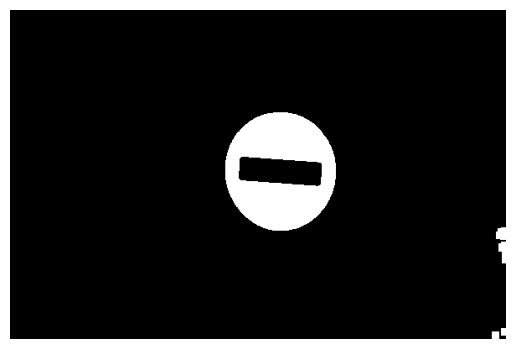

Контур самый большой


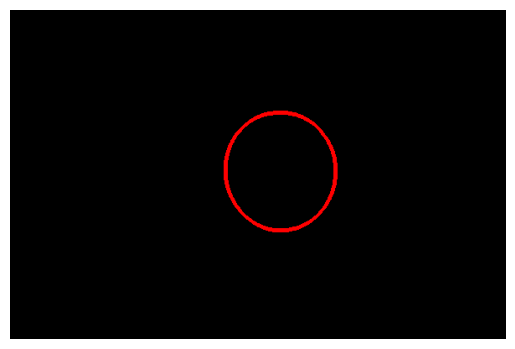

In [5]:
imageUrl = "https://habrastorage.org/r/w1560/getpro/habr/upload_files/13a/8bb/bb5/13a8bbbb52f60bad2637a2fb6fd3c725.png"
baseImage = io.imread(imageUrl)

image = cv.cvtColor(baseImage, cv.COLOR_BGR2RGB)
print("Оригнальное изображение")
Shower.show_img(image, in_gray=False)


img_detect_hsv = ImgDetectionsHSV(color='red')
threshold = img_detect_hsv.find_by_color(baseImage, image)

img_detect_hsv.find_contour(threshold, image)

Оригнальное изображение


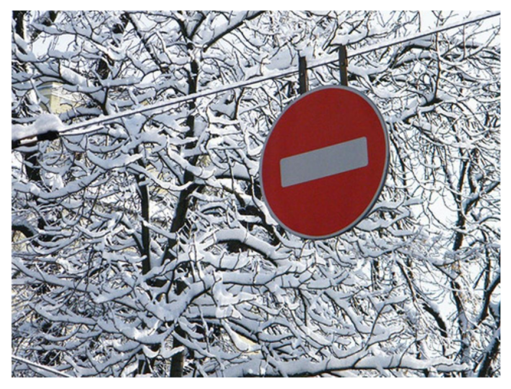

Цветовой канал


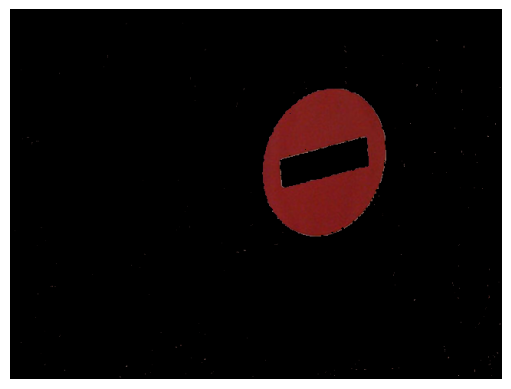

Изображение после открытия


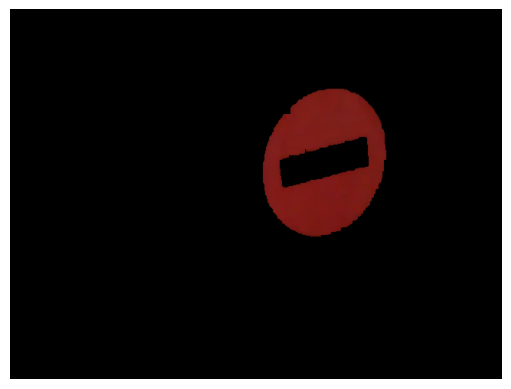

Изображение после конвертации в HSV


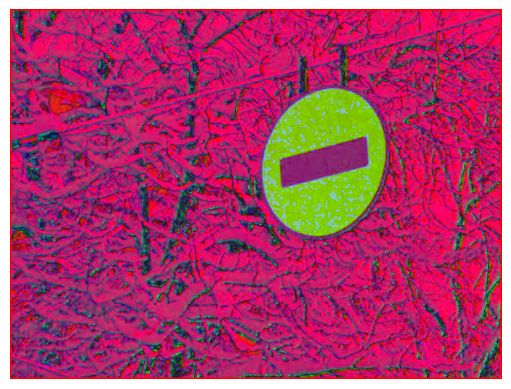

Изображение после наложения маски для унификации цвета


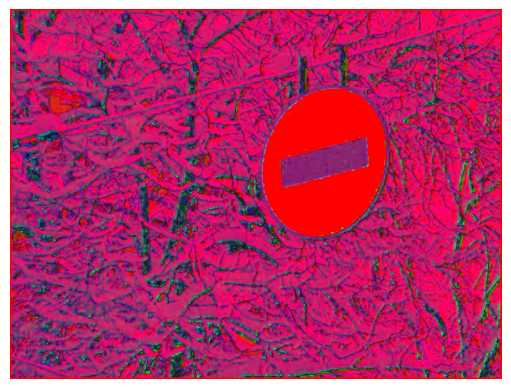

RGB Изображение после наложения маски


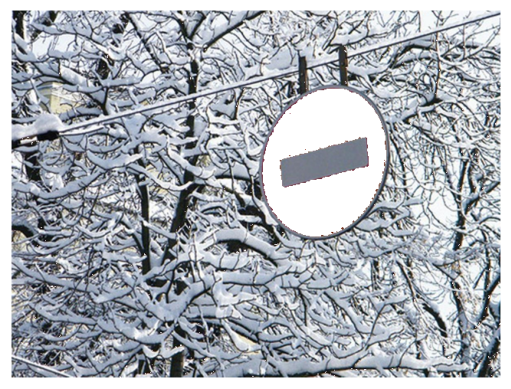

Изображение после преобразования HSV к оттенкам серого


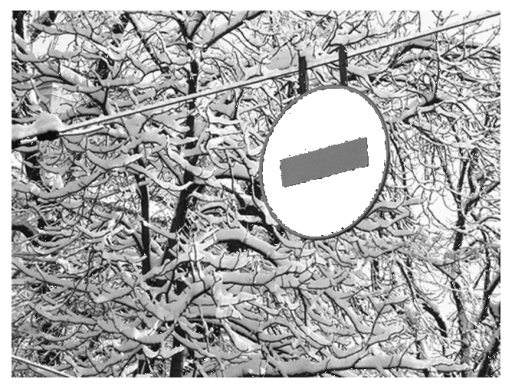

Пороговое изображение


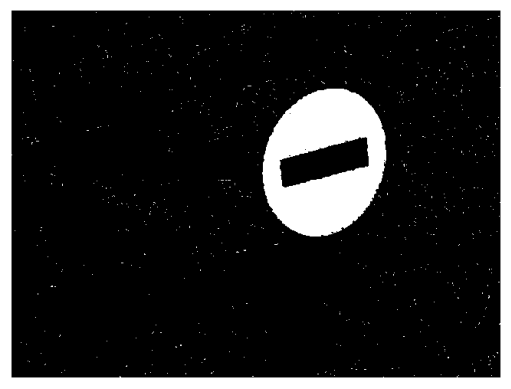

Контур


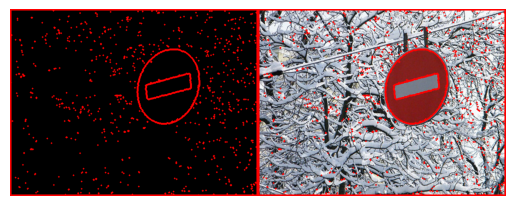

Изображение после открытия


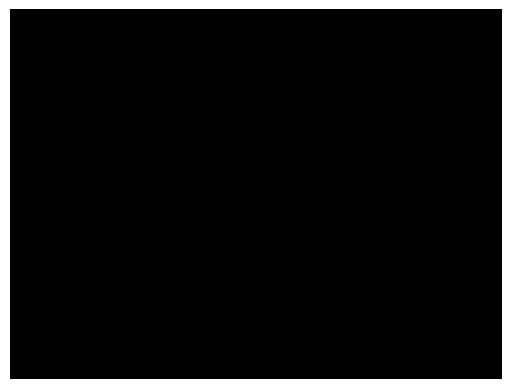

Контур


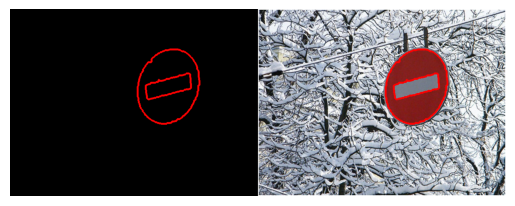

Изображение после открытия


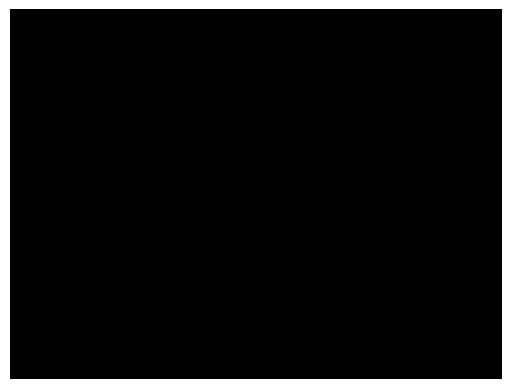

Открытие на пороговое изображение


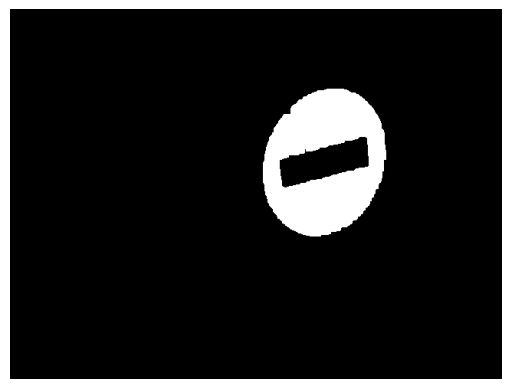

Контур самый большой


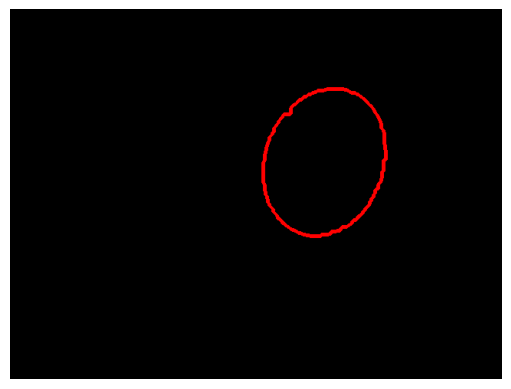

In [6]:
# Проверим наш метод на другом изображении
imageUrl2 = "https://habrastorage.org/r/w1560/getpro/habr/upload_files/cc2/a6a/679/cc2a6a679de23ddb153a686bcde33671.png"
baseImage2 = io.imread(imageUrl2)

image = cv.cvtColor(baseImage2, cv.COLOR_BGR2RGB)
print("Оригнальное изображение")
Shower.show_img(image, in_gray=False)


img_detect_hsv = ImgDetectionsHSV(color='red')
threshold = img_detect_hsv.find_by_color(baseImage2, image)

img_detect_hsv.find_contour(threshold, image)

# Homework

In [7]:
PICTURE1_PATH = 'materials/imgs/green_circles2.png'

## Task 1

 Написать программу
которая выполняет
поиск объекта на
изображении по цвету
(HSV)

Оригнальное изображение


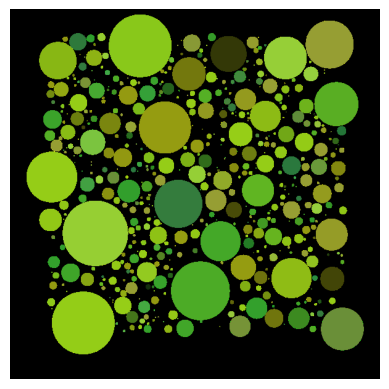

Цветовой канал


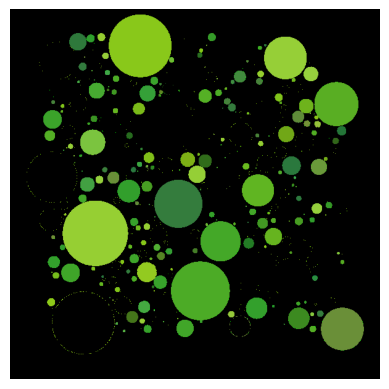

Изображение после открытия


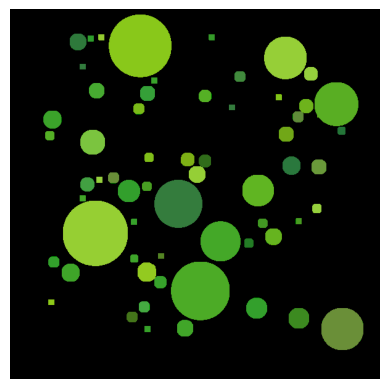

Изображение после конвертации в HSV


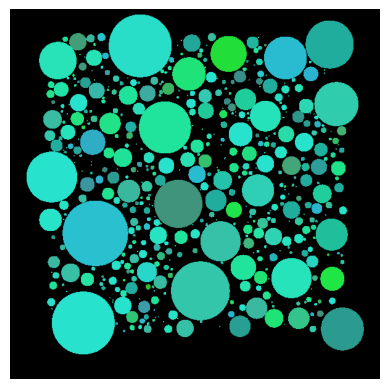

Изображение после наложения маски для унификации цвета


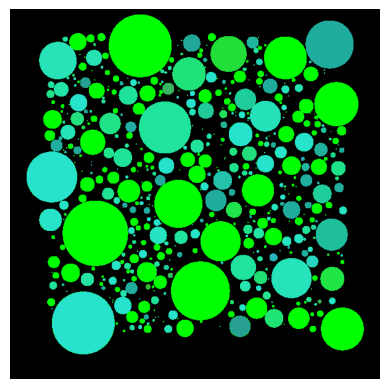

RGB Изображение после наложения маски


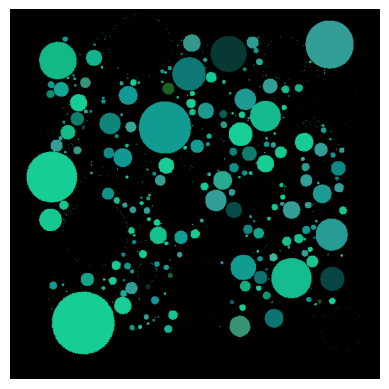

Изображение после преобразования HSV к оттенкам серого


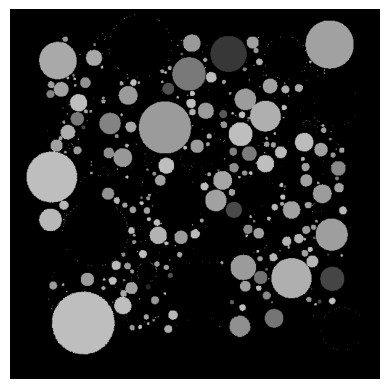

Пороговое изображение


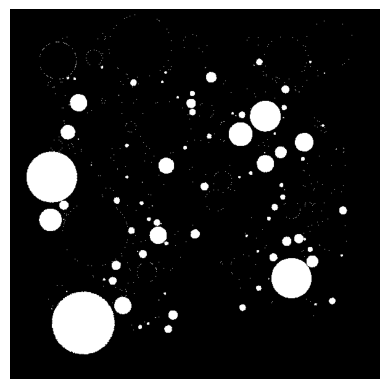

In [8]:
image = cv2.cvtColor(cv2.imread(PICTURE1_PATH), cv2.COLOR_BGRA2RGB)

print("Оригнальное изображение")
Shower.show_img(image, in_gray=False, in_brg=False)


img_detect_hsv = ImgDetectionsHSV(color='green', threshold=150)
threshold = img_detect_hsv.find_by_color(image, image, in_brg=False)

## Task 2

Написать программу
которая выполняет
поиск контура объекта 

Контур


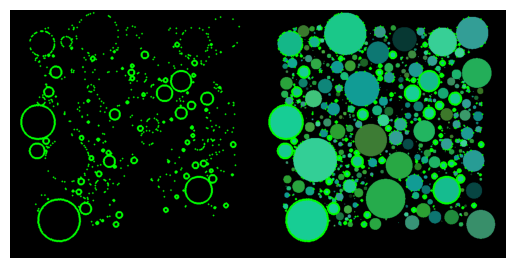

Изображение после открытия


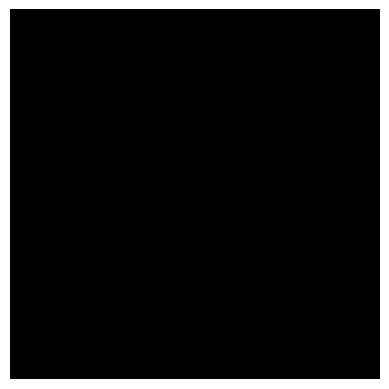

Контур


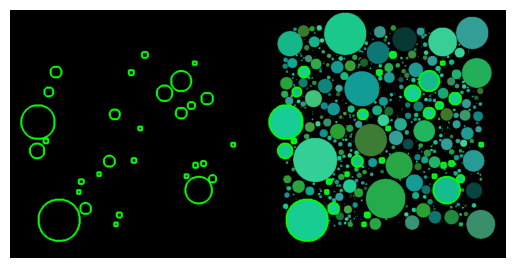

Изображение после открытия


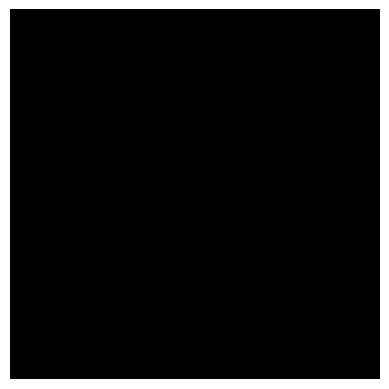

Открытие на пороговое изображение


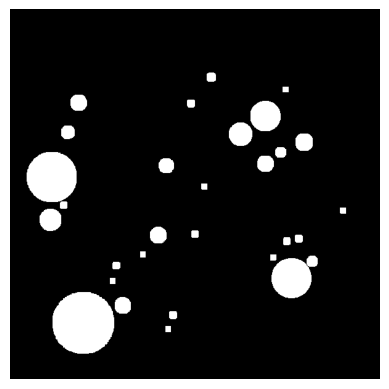

Контур самый большой


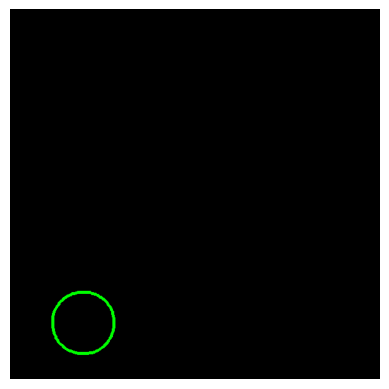

In [9]:
img_detect_hsv.find_contour(threshold, image)